In [44]:
import matplotlib.pyplot as plt
from sklearn.metrics import PrecisionRecallDisplay
import numpy as np
import json
import requests
import pandas as pd
import sys

sys.path.append('../../')
from utils.metrics import calculate_metric


### Create sample df


In [45]:
# df = pd.read_csv('../data/data.csv')

# christmas_sample = ['tt1430607', 'tt13381368', 'tt0104940',  'tt13320784', 'tt13356246', 'tt6269192', 'tt0319343', 'tt0314331', 'tt0107688', 'tt3626180',  'tt1519929', 'tt1327788', 'tt2990140']
# space_sample = ['tt1182345', 'tt1446714', 'tt1454468', 'tt0448134', 'tt0816692', 'tt0119116', 'tt0119177', 'tt0118884', 'tt0796366', 'tt1408101', 'tt0134847', 'tt2015381', 'tt3659388', 'tt3896198', 'tt0379786', 'tt3748528','tt21157976', 'tt15609374', 'tt12483148', 'tt5597272', 'tt14191506', 'tt7794734', 'tt11771702', 'tt9782756', 'tt13347662', 'tt4372340', 'tt7918178', 'tt3351386', 'tt6024606', 'tt4859370', 'tt12787166', 'tt15663664']
# teen_sample = ['tt0435679', 'tt2582846', 'tt2582496', 'tt2962876', 'tt1714206', 'tt0910970', 'tt1282140', 'tt0377092', 'tt2205697', 'tt0398286', 'tt0109830', 'tt1798709', 'tt0467406', 'tt2980648', 'tt1659337', 'tt1010048', 'tt0817177', 'tt0181875', 'tt0338013', 'tt0338013', 'tt1924396', 'tt0414387', 'tt0332280', 'tt0462610', 'tt1838737', 'tt3846674', 'tt6472976', 'tt1638002', 'tt2674426', 'tt0147800', 'tt1022603', 'tt3783958', 'tt2194499']

# relevant_ids = christmas_sample + space_sample + teen_sample;

# filtered_df = df[~df['tconst'].isin(relevant_ids)]
# relevant_sample = df[df['tconst'].isin(relevant_ids)]

# sample = filtered_df.sample(n=222)
# sample.append(relevant_sample)

# sample["genres"] = sample["genres"].str.split(',')
# sample["directors"] = sample["directors"].str.split(',')
# sample.to_csv('../data/sample_data.csv', index=False)
# sample.to_json('../data/sample_data.json' orient='records')


### Evaluation


In [46]:
CHRISTMAS_QRELS_FILE = "../qrels_files/christmas_movies.txt"
ROMANCE_TEEN_QRELS_FILE = "../qrels_files/romance_teen.txt"
SPACE_QRELS_FILE = "../qrels_files/space_movies.txt"

CHRISTMAS_BASIC_QUERY_URL = "http://localhost:8983/solr/imdb_movies/select?defType=dismax&fl=*%20score&indent=true&q.op=OR&q=christmas%5E2%20santa%5E2%20snow%20elf%20rodolf%20festive%20claus%20merry%20holliday%20%22candy%20cane%22%20%22christmas%20tree%22%20eve%20advent&qf=originalTitle%20primaryTitle%20synopsis&tie=0.1&rows=300"
CHRISTMAS_BOOSTED_QUERY_URL = "http://localhost:8983/solr/imdb_movies/select?bq=primaryTitle%3A%20christmas%5E5.0%20synopsis%3Achristmas%5E3&defType=dismax&fl=score%20*&indent=true&q.op=OR&q=christmas%5E2%20santa%5E2%20snow%20elf%20rodolf%20festive%20claus%20merry%20holliday%20%22candy%20cane%22%20%22christmas%20tree%22%20eve%20advent&qf=originalTitle%5E1.5%20primaryTitle%5E1.5%20synopsis%5E2&tie=0.1&rows=300"

SPACE_BASIC_QUERY_URL = "http://localhost:8983/solr/imdb_movies/select?defType=dismax&fl=score%20*&indent=true&q.op=OR&q=space%20astronaut%20galaxy%20planets&qf=originalTitle%20primaryTitle%20synopsis&tie=0.1&rows=300"
SPACE_BOOSTED_QUERY_URL = "http://localhost:8983/solr/imdb_movies/select?bq=genres%3Asci-fi%5E3.0%20synopsis%3Astars&defType=dismax&fl=score%20*&indent=true&q.op=OR&q=space%20astronaut%20galaxy%20planets&qf=originalTitle%5E1.5%20primaryTitle%5E1.5%20synopsis%5E2&tie=0.1&rows=300"

ROMANCE_BASIC_TEEN_QUERY_URL = "http://localhost:8983/solr/imdb_movies/select?defType=dismax&fl=*%20score&indent=true&q.op=OR&q=romance%20teen%20crush%20heart-break%20%22in%20love%22%20high-school%20college%20friends%20friendship%20campus%20gossip%20passion%20attraction&qf=originalTitle%20primaryTitle%20synopsis&tie=0.1&rows=300"
ROMANCE_BOOSTED_TEEN_QUERY_URL = "http://localhost:8983/solr/imdb_movies/select?bq=genres%3Adrama%20genres%3Aromance%20synopsis%3Acrush%5E2.0&defType=dismax&indent=true&q.op=OR&q=romance%20teen%5E3.0%20crush%20heart-break%5E3.0%20%5C%5C%5C%22in%20love%5C%5C%5C%22%5E2.0%20high-school%5E2.0%20college%20friends%20friendship%20campus%20gossip%20passion%20attraction&qf=originalTitle%5E1.5%20primaryTitle%5E1.5%20synopsis%5E4&tie=0.1"


In [47]:
info = {
    "christmas_movies": {
        "basic_query_url": CHRISTMAS_BASIC_QUERY_URL,
        "boosted_query_url": CHRISTMAS_BOOSTED_QUERY_URL,
        "qrels_file": CHRISTMAS_QRELS_FILE,
    },
    "space_movies": {
        "basic_query_url": SPACE_BASIC_QUERY_URL,
        "boosted_query_url": SPACE_BOOSTED_QUERY_URL,
        "qrels_file": SPACE_QRELS_FILE,
    },
    "romance_teen_movies": {
        "basic_query_url": ROMANCE_BASIC_TEEN_QUERY_URL,
        "boosted_query_url": ROMANCE_BOOSTED_TEEN_QUERY_URL,
        "qrels_file": ROMANCE_TEEN_QRELS_FILE,
    },
}

In [48]:
def get_title(movie_type, type):
    movie_type = movie_type.replace("_", " ")
    movie_type = movie_type[0].upper() + movie_type[1:]

    return f"{movie_type} {type} query PR Curve"

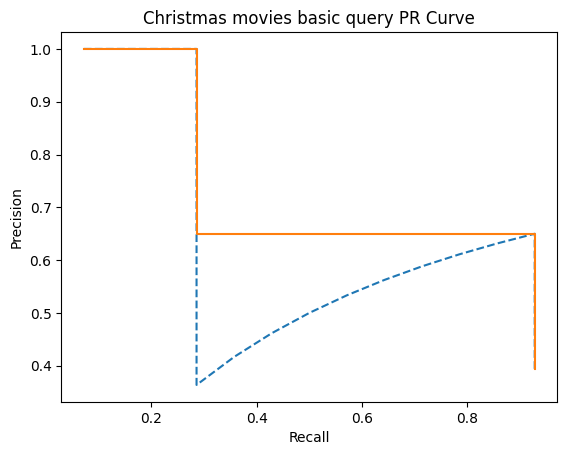

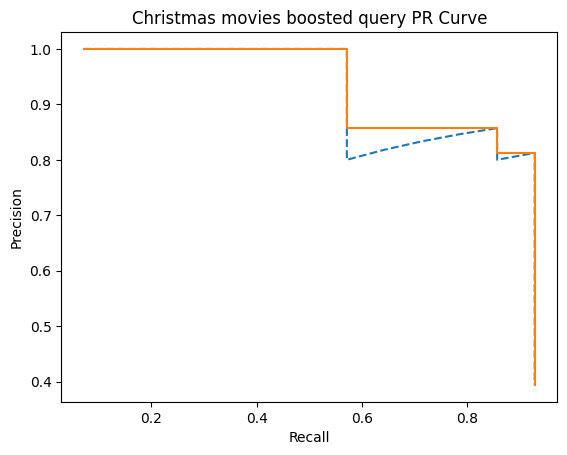

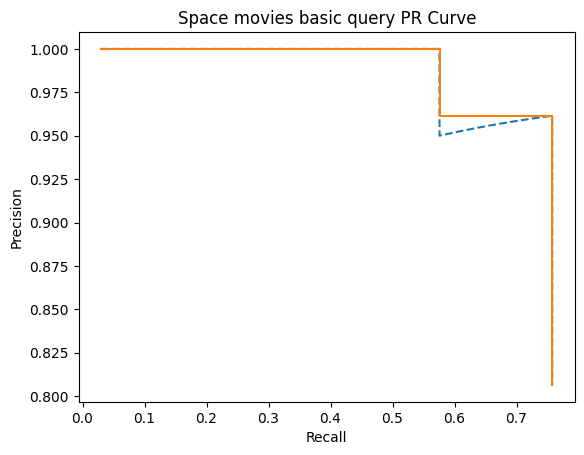

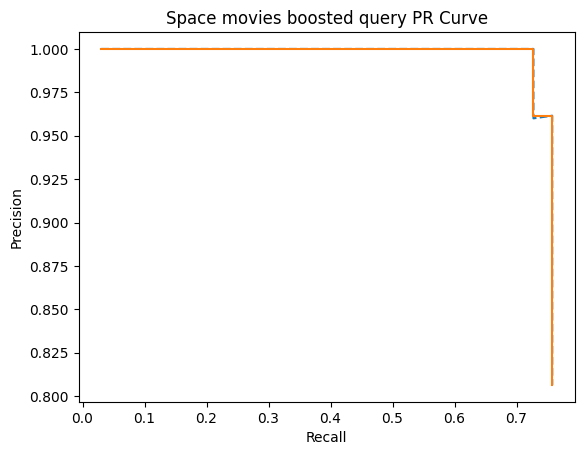

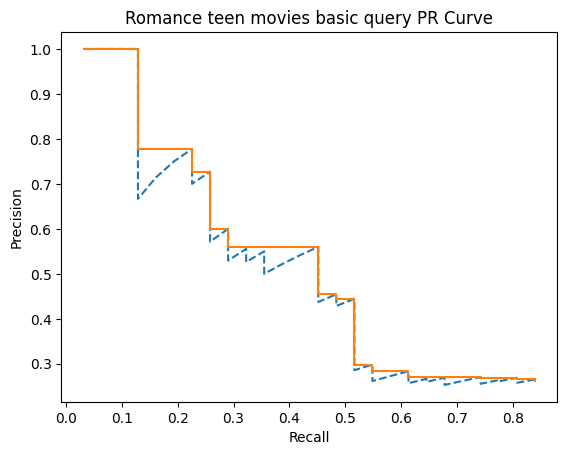

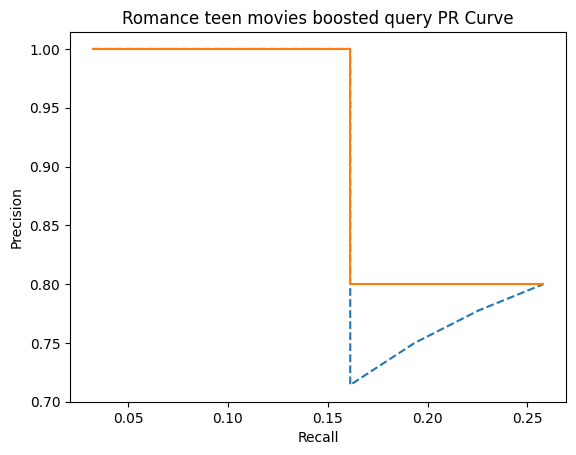

In [49]:
DEBUG = False
ENHANCED = False

basic_average_precisions = []
boosted_average_precisions = []

for movie_type, paths in info.items():
    # Read qrels to extract relevant documents
    relevant = list(map(lambda el: el.strip(), open(paths['qrels_file']).readlines()))

    # Get query results from Solr instance
    basic_results = requests.get(paths['basic_query_url']).json()["response"]["docs"]
    boosted_results = requests.get(paths['boosted_query_url']).json()["response"]["docs"]
    

    # Define metrics to be calculated
    evaluation_metrics = {
        "ap": "Global Average Precision", "ap10": "Average Precision at 10 (AP@10)",
        "p10": "Precision at 10 (P@10)", "p15": "Precision at 15 (P@15)",
        "ia": "Individual Assessment (IA@10)"
    }

    # Calculate all metrics and export results as LaTeX table
    df_basic = pd.DataFrame(
        [
            [evaluation_metrics[m], calculate_metric(m, basic_results, relevant)]
            for m in evaluation_metrics
        ],
        columns=["Metric", "Value"]
    )

    df_boosted = pd.DataFrame(
        [
            [evaluation_metrics[m], calculate_metric(m, boosted_results, relevant)]
            for m in evaluation_metrics
        ], 
        columns=["Metric", "Value"]
    )

    basic_average_precisions.append(calculate_metric("ap", basic_results, relevant))
    boosted_average_precisions.append(calculate_metric("ap", boosted_results, relevant))

    if not DEBUG:
        with open(f"../results/{movie_type}/{'schema_enhanced_' if ENHANCED else ''}basic_metrics.tex", "w") as tf:
            tf.write(df_basic.style.to_latex())
        with open(f"../results/{movie_type}/{'schema_enhanced_' if ENHANCED else ''}boosted_metrics.tex", "w") as tf:
            tf.write(df_boosted.style.to_latex())

    results = [(basic_results, "basic"), (boosted_results, "boosted")]

    # PRECISION-RECALL CURVE
    # Calculate precision and recall values as we move down the ranked list
    for (result, type) in results:
        precision_values = [
            len([doc for doc in result[:idx] if doc["tconst"] in relevant]) / idx
            for idx, _ in enumerate(result, start=1)
        ]

        recall_values = [
            len([doc for doc in result[:idx] if doc["tconst"] in relevant]) / len(relevant)
            for idx, _ in enumerate(result, start=1)
        ]

        # Plot precision-recall curve
        fig, ax = plt.subplots(1, 1)
        ax.plot(recall_values, precision_values, '--C0')
        decreasing_max_precision = np.maximum.accumulate(precision_values[::-1])[::-1]
        ax.step(recall_values, decreasing_max_precision, '-C1')

        plt.title(get_title(movie_type, type))
        plt.ylabel("Precision")
        plt.xlabel("Recall")
        if not DEBUG:
            plt.savefig(f"../results/{movie_type}/{'schema_enhanced_' if ENHANCED else ''}{type}_precision_recall.pdf")

data = [
    ["Basic Mean Average Precision", calculate_metric("map", basic_average_precisions)],
    ["Boosted Mean Average Precision", calculate_metric("map", boosted_average_precisions)],
]
df = pd.DataFrame(data=data, columns=["Metric", "Value"])

if not DEBUG:
    with open(f"../results/{'schema_enhanced_' if ENHANCED else ''}map.tex", "w") as tf:
        tf.write(df.style.to_latex())
